The Method of GAN is taken from the min max game
The Model Implimentation is with Convolution Layers 

In [2]:
import numpy as np
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, LeakyReLU, BatchNormalization, Conv2D  , Flatten , Dropout, Conv2DTranspose,Reshape
from keras.models import Sequential
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.datasets.mnist import  load_data
from matplotlib import pyplot

In [3]:
(train_x,train_y),(test_x,test_y) = load_data()
print('Shape of the Training Dataset {}'.format(train_x.shape))
print('Shape of the Test Dataset {}'.format(test_x.shape))


11493376/11490434 [==============================] - 0s 0us/step
Shape of the Training Dataset (60000, 28, 28)
Shape of the Test Dataset (10000, 28, 28)


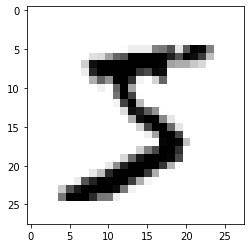

In [4]:
plt.imshow(train_x[0],cmap='gray_r') 

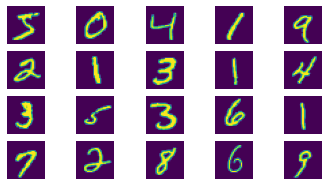

In [5]:
for i in range(20):
  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(train_x[i])
pyplot.show()

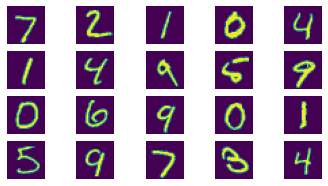

In [6]:
for i in range(20):
  pyplot.subplot(5, 5, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(test_x[i])
pyplot.show()

## Discriminator Model 
- Takes input of the images in shape (28,28,1)  
- Provides an output of Binary Classification(0 or 1) 
-  Aims to Minimize the Binary Cross Entropy
- The architecture consists of 2 Convolution layers with 64 filters and adopted the best practises including drop out ,Adam optimizer, leaky relu after each activation function 
- stride of 2(down sample image ) and 3 x 3 filter size used at each conv layer and mapping the final output as one within the range of 0 to 1 done using sigmoid  to predict the output as real/fake

In [30]:
def discriminator(in_shape= (28,28,1)):
  model = Sequential(name = 'Discrim')
  model.add(Conv2D(strides=(2,2),padding='same',filters=64,kernel_size=(3,3),input_shape = in_shape ))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(rate=0.4))
  model.add(Conv2D(strides=(2,2),padding='same',filters=64,kernel_size=(3,3) ))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(rate=0.4))
  model.add(Flatten())
  model.add(Dense(1 , activation='sigmoid'))
  opt = Adam(learning_rate= 0.001)
  model.compile(loss = 'binary_crossentropy',optimizer = opt , metrics = ['accuracy'])
  return model

In [8]:
disc = discriminator()

In [9]:
disc.summary()

Model: "Discrim"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0   

In [10]:
train_x.shape
train_x.reshape(60000,28,28,1).shape # currently the input data does not have channel dimension

(60000, 28, 28, 1)

In [11]:
np.expand_dims(train_x,axis=-1).shape

(60000, 28, 28, 1)

In [12]:
train_x[0].astype('float32') / 255.0 # Typical Normalizing of pixelvalues between 0 and 1

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    

- As per the above illustration we will first expand the dimension of our sample dataset , then we will normalize the pixel values as preprocessing steps
- Training Discriminator requires interchangebily training with shuffled real data and fake data 
- We create function for generating random n size of sample from our orignal dataset with class label 1
- We create function for generating fake data of n size of sample as a class label 0

In [13]:
def preprocess(dataset):
  dataset = np.expand_dims(dataset,axis=-1).astype('float32') # Adding Channel Axis
  dataset = dataset / 255.0     # Normalize the range of Data (0 or 1) pixel value between 0 and 1
  return dataset

# To reconstruct back the image
def deprocess(x):
    x = (x / 2 + 1) * 255
    x = np.clip(x, 0, 255)
    x = np.uint8(x)
    x = x.reshape(28, 28,1)
    return x

In [14]:
def gen_real_data(dataset,sample_size):
  idx = np.random.randint(0, dataset.shape[0], sample_size)# random instances
  data = dataset[idx]  # extract images
  labels = np.ones((sample_size,1)) # generating real labels
  return data , labels

def gen_fake_data(sample_size):
  data = np.random.rand(28*28*sample_size)
  data = data.reshape((sample_size,28,28,1))
  labels = np.zeros((sample_size,1))
  return data,labels

In [15]:
def train_discrim(dataset,model,n_iter = 100 , batch_size = 256):
  half_batch = int(batch_size / 2)
  for i in range(n_iter):
    real_data,real_label = gen_real_data(dataset,half_batch)
    _,real_accu = model.train_on_batch(real_data,real_label)
    fake_data,fake_label = gen_fake_data(half_batch)
    _,fake_accu = model.train_on_batch(fake_data,fake_label)
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_accu*100, fake_accu*100))

In [16]:
model = discriminator()
dataset = preprocess(train_x)
train_discrim(dataset,model)

>1 real=69% fake=1%
>2 real=97% fake=40%
>3 real=99% fake=100%
>4 real=96% fake=100%
>5 real=94% fake=100%
>6 real=95% fake=100%
>7 real=92% fake=100%
>8 real=95% fake=100%
>9 real=93% fake=100%
>10 real=97% fake=100%
>11 real=98% fake=100%
>12 real=98% fake=100%
>13 real=100% fake=100%
>14 real=100% fake=100%
>15 real=100% fake=100%
>16 real=100% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%
>21 real=100% fake=100%
>22 real=100% fake=100%
>23 real=100% fake=100%
>24 real=100% fake=100%
>25 real=100% fake=100%
>26 real=100% fake=100%
>27 real=100% fake=100%
>28 real=100% fake=100%
>29 real=100% fake=100%
>30 real=100% fake=100%
>31 real=100% fake=100%
>32 real=100% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fa

## Generator Model
- We begin with generating a low res image and upsampling it at each layer to higher resolution to finally provide a image of shape resembling to real input shape
- Provides meaning to the latent space points which are taken as input
- Takes input from latent space outputs square image with 28x28 image pixels ranging between [0,1]( ensured by using sigmoid ) 
- We use the DeConvolution approach to upsample the low resolution image to high res image
- The generator architecture is not provided with loss function and optimizer as the parameters are learnt through the GAN architecture where the training of discriminator is frozen 

In [17]:
def generator(latent_space):
  model = Sequential(name='Generator')
  base_image = 128 * 7 * 7  # 6272 shape
  model.add(Dense(base_image,input_dim=latent_space))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128))) # 7x7x128(Quarter the size of real image)
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')) # 14x14x128
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')) # 28x28x1
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1,(4,4),padding='same',activation='sigmoid')) # 28x28x1
  return model

In [18]:
gen = generator(100)
gen.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)       0 

In [19]:
def gen_latent_space(latentspace,n_samples):
  return np.random.uniform(-1,size=(n_samples,latentspace))

# updating the fake data generation method(we use the generator model to generate fake samples) 
def gen_fake_data(model,latent_dim,n_sample):
  x_input = gen_latent_space(latent_dim,n_sample)
  X = model.predict(x_input)
  labels = np.zeros((n_sample,1))
  return X,labels

In [20]:
data,labels = gen_fake_data(gen,100,128)

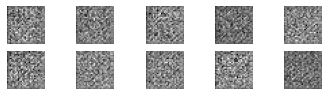

In [21]:
for i in range(10):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(data[i, :, :, 0], cmap='gray_r')

## GAN Architecture

In [22]:
# Stand Alone Discriminator
def discriminator(in_shape= (28,28,1)):
  model = Sequential()
  model.add(Conv2D(strides=(2,2),padding='same',filters=64,kernel_size=(3,3),input_shape = in_shape ))
  model.add(LeakyReLU(alpha=0.02))
  model.add(Dropout(rate=0.2))
  model.add(Conv2D(strides=(2,2),padding='same',filters=64,kernel_size=(3,3) ))
  model.add(LeakyReLU(alpha=0.02))
  model.add(Dropout(rate=0.2))
  model.add(Flatten())
  model.add(Dense(1 , activation='sigmoid'))
  opt = Adam(learning_rate= 0.0002)
  model.compile(loss = 'binary_crossentropy',optimizer = opt , metrics = ['accuracy'])
  return model

# Stand Alone Generator
def generator(latent_space):
  model = Sequential(name='Generator')
  base_image = 128 * 7 * 7 
  model.add(Dense(base_image,input_dim=latent_space))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((7,7,128))) # 7x7x128
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')) # 14x14x128
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding='same')) # 28x28x1
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1,(4,4),padding='same',activation='sigmoid')) # 28x28x1
  return model

# Compilation of Generator and Discriminator
# here we update the params of generator
def gan( gen_model,disc_model):
  disc_model.trainable = False  # we dont want the discriminator to overtrain  fake example 
  model = Sequential()
  model.add(gen_model)
  model.add(disc_model)
  opt = Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss='binary_crossentropy',optimizer=opt)
  return model
latent_space = 100
disc_model = discriminator()
gen_model = generator(latent_space)
gan_Model = gan(gen_model,disc_model)
gan_Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Sequential)       (None, 28, 28, 1)         1160065   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 40705     
Total params: 1,200,770
Trainable params: 1,160,065
Non-trainable params: 40,705
_________________________________________________________________


In [23]:
def train_gan(gan_model,latent_space,epoch=100,n_batch=256):
  for i in range(epoch):
    data = gen_latent_space(latent_space,n_batch) # data points in latent space generated
    labels = np.ones((n_batch,1))
    gan_model.train_on_batch(data,labels)

In [24]:
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [25]:
def evaluation_metric(latent_dim,dataset,d_model,g_model,epoch,n_sample= 100):
  real_image,real_label = gen_real_data(dataset,n_sample,verbose = False)
  _,disc_accuracy = d_model.evaluate(real_image,real_label)
  fake_image,fake_label = gen_fake_data(g_model,latent_dim,n_sample,verbose =False)
  _,gen_accu = d_model.evaluate(fake_image,fake_label)
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (disc_accuracy*100, gen_accu*100))
  save_plot(fake_image,epoch)
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)

In [28]:
def training_gan(latent_dim,dataset,d_model,g_model,number_batches=256,epoch=100):
  batch_per_epoch = int(dataset.shape[0] / number_batches)
  half_batch = int(number_batches / 2)
  for i in range(epoch):
    for j in range(batch_per_epoch):
      real_data,real_label = gen_real_data(dataset,half_batch)
      fake_data,fake_label = gen_fake_data(g_model,latent_dim,half_batch)
      data,labels = np.vstack((real_data,fake_data)), np.vstack((real_label,fake_label))
      disc_loss , _ = d_model.train_on_batch(data,labels)
      latent_points = gen_latent_space(latent_space,number_batches)
      labels = np.ones((number_batches,1))
      gen_loss  = gan_Model.train_on_batch(latent_points,labels)
      print('>%d, %d/%d, discriminator_loss=%.3f, generator_loss=%.3f' % (i+1, j+1, batch_per_epoch, disc_loss, gen_loss))
    
    if (i+1) % 10 == 0:
      evaluation_metric(latent_dim,dataset,d_model,g_model,i)
		  

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = discriminator()
# create the generator
g_model = generator(latent_dim)
# create the gan
gan_model = gan(g_model,d_model)
# load image data
dataset = preprocess(train_x)
# train model
training_gan(latent_dim,dataset,d_model,g_model)

>3, 74/234, discriminator_loss=0.000, generator_loss=0.372
>3, 75/234, discriminator_loss=0.000, generator_loss=0.372
>3, 76/234, discriminator_loss=0.000, generator_loss=0.370
>3, 77/234, discriminator_loss=0.000, generator_loss=0.371
>3, 78/234, discriminator_loss=0.000, generator_loss=0.370
>3, 79/234, discriminator_loss=0.000, generator_loss=0.371
>3, 80/234, discriminator_loss=0.000, generator_loss=0.371
>3, 81/234, discriminator_loss=0.000, generator_loss=0.371
>3, 82/234, discriminator_loss=0.000, generator_loss=0.372
>3, 83/234, discriminator_loss=0.000, generator_loss=0.371
>3, 84/234, discriminator_loss=0.000, generator_loss=0.371
>3, 85/234, discriminator_loss=0.000, generator_loss=0.371
>3, 86/234, discriminator_loss=0.000, generator_loss=0.371
>3, 87/234, discriminator_loss=0.000, generator_loss=0.372
>3, 88/234, discriminator_loss=0.000, generator_loss=0.370
>3, 89/234, discriminator_loss=0.000, generator_loss=0.371
>3, 90/234, discriminator_loss=0.000, generator_loss=0.3

In [ ]:
dataset.shape